In [1]:
%matplotlib inline
import openpathsampling as paths
import numpy as np
import matplotlib.pyplot as plt
import os
import openpathsampling.visualize as ops_vis
from IPython.display import SVG

# Analyzing the flexible path length simulation

Load the file, and from the file pull our the engine (which tells us what the timestep was) and the move scheme (which gives us a starting point for much of the analysis).

In [2]:
filename = "tps_nc_files/alanine_dipeptide_tps.nc"

In [3]:
# note that this log will overwrite the log from the previous notebook
#import logging.config
#logging.config.fileConfig("logging.conf", disable_existing_loggers=False)

In [4]:
%%time
flexible = paths.AnalysisStorage(filename)

CPU times: user 1min 40s, sys: 9.03 s, total: 1min 49s
Wall time: 5min 24s


In [5]:
engine = flexible.engines[0]
flex_scheme = flexible.schemes[0]

In [6]:
print "File size: {0} for {1} steps, {2} snapshots".format(
    flexible.file_size_str,
    len(flexible.steps),
    len(flexible.snapshots)
)

File size: 17.95GB for 10001 steps, 946650 snapshots


In [7]:
# rough estimate of total time
sum(step.change.details.timing for step in flexible.steps if step.change.details is not None)

0

In [8]:
step = flexible.steps[1]
step.change.details

That tell us a little about the file we're dealing with. Now we'll start analyzing the contents of that file. We used a very simple move scheme (only shooting), so the main information that the `move_summary` gives us is the acceptance of the only kind of move in that scheme. See the MSTIS examples for more complicated move schemes, where you want to make sure that frequency at which the move runs is close to what was expected.

In [9]:
flex_scheme.move_summary(flexible.steps)

shooting ran 100.000% (expected 100.00%) of the cycles with acceptance 5616/10000 (56.16%)


#### Replica history tree and decorrelated trajectories

The `ReplicaHistoryTree` object gives us both the history tree (often called the "move tree") and the number of decorrelated trajectories.

A `ReplicaHistoryTree` is made for a certain set of Monte Carlo steps. First, we make a tree of only the first 50 steps in order to visualize it. (All 10000 steps would be unwieldy.) 

After the visualization, we make a second `ReplicaHistoryTree` of all the steps, in order to count the number of decorrelated trajectories.

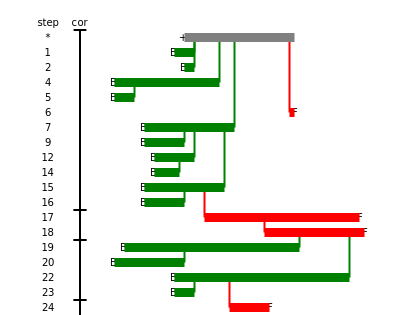

In [10]:
tree = ops_vis.PathTree(
    flexible.steps[0:25],
    ops_vis.ReplicaEvolution(
        replica=0
    )
)

SVG(tree.svg())

In [11]:
print "Decorrelated trajectories:", len(tree.generator.decorrelated_trajectories)

Decorrelated trajectories: 4


#### Path length distribution

Flexible length TPS gives a distribution of path lengths. Here we calculate the length of every accepted trajectory, then histogram those lengths, and calculate the maximum and average path lengths.

We also use `engine.snapshot_timestep` to convert the count of frames to time, including correct units.

Maximum: 528 (10.56 ps)
Average: 84.14 (1.683 ps)


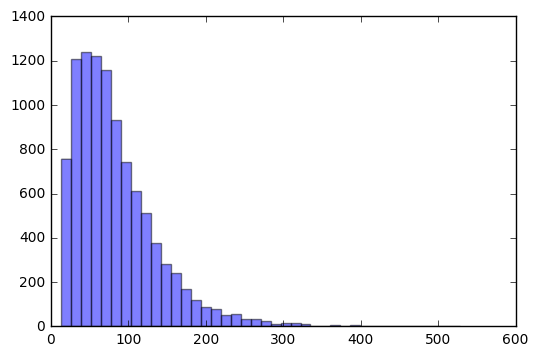

In [12]:
path_lengths = [len(step.active[0].trajectory) for step in flexible.steps]
plt.hist(path_lengths, bins=40, alpha=0.5);
print "Maximum:", max(path_lengths), "("+str(max(path_lengths)*engine.snapshot_timestep)+")"
print "Average:", "{0:.2f}".format(np.mean(path_lengths)), "("+(np.mean(path_lengths)*engine.snapshot_timestep).format("%.3f")+")"

#### Path density histogram

Next we will create a path density histogram. Calculating the histogram itself is quite easy: first we reload the collective variables we want to plot it in (we choose the phi and psi angles). Then we create the empty path density histogram, by telling it which CVs to use and how to make the histogram (bin sizes, etc). Finally, we build the histogram by giving it the list of active trajectories to histogram.

In [13]:
from openpathsampling.analysis import HistogramPlotter2D

In [14]:
psi = flexible.cvs['psi']
phi = flexible.cvs['phi']
deg = 180.0 / np.pi

In [15]:
path_density = paths.PathDensityHistogram(cvs=[phi, psi],
                                          left_bin_edges=(-180/deg,-180/deg),
                                          bin_widths=(2.0/deg,2.0/deg))

In [16]:
# TODO: can we pre-cache all the trajectories, too? That might make this faster....
flexible.trajectories.cache_all()

In [17]:
%%time
path_dens_counter = path_density.histogram([s.active[0].trajectory for s in flexible.steps[::10]])
# TODO: for the real then, run over *all* steps -- just takes 10 times longer

CPU times: user 11min 35s, sys: 7.55 s, total: 11min 42s
Wall time: 14min 34s


Now we've built the path density histogram, and we want to visualize it. We have a convenient `plot_2d_histogram` function that works in this case, and takes the histogram, desired plot tick labels and limits, and additional `matplotlib` named arguments to `plt.pcolormesh`.

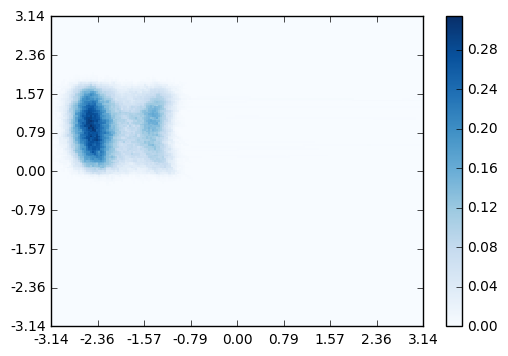

In [18]:
tick_labels = np.arange(-np.pi, np.pi+0.01, np.pi/4)
plotter = HistogramPlotter2D(path_density, 
                             xticklabels=tick_labels,
                             yticklabels=tick_labels, 
                             label_format="{:4.2f}")
ax = plotter.plot(cmap="Blues")

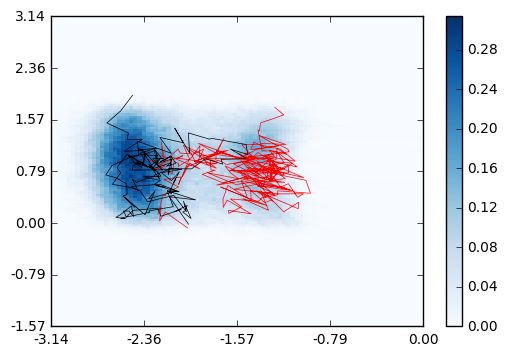

In [19]:
ax = plotter.plot(xlim=(-np.pi, 0), ylim=(-np.pi/2, np.pi), cmap="Blues")
trajA = flexible.steps[1000].active[0].trajectory
trajB = flexible.steps[2000].active[0].trajectory
plotter.plot_trajectory(trajA, '-r', lw=0.5)
plotter.plot_trajectory(trajB, '-k', lw=0.5)
plt.savefig("AD_tps_pathdensity.pdf")

In [20]:
#import nglview as nv
#nv.show_mdtraj(traj.to_mdtraj())